# TME 7. Continuous Actions

In [1]:
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
from utils_rdl import smooth

import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

matplotlib.use("TkAgg")

import gym
import gridworld
from gym import wrappers, logger

import io
import base64
from IPython.display import HTML
from attr_dict import AttrDict


Using matplotlib backend: Qt5Agg


In [2]:
from utils_rdl import NN, AleaStock, MultiInputNN, Orn_Uhlen, OUNoise
from utils_rdl import play_one_run, train_agent
from utils_rdl import GridWorldMethods, GridWorldFeaturesMethods, CartPoleDiscreteMethods, LunarLanderDiscreteMethods
from utils_rdl import MountainCarContinuousMethods, PendulumContinuousMethods, LunarLanderContinuousMethods
from utils_rdl import BaseAgent, BaseMemAgent, BaseBatchEpisodeAgent


## DDPG

In [3]:
class Actor(nn.Module):
    def __init__(self, inDim, outDim, layers, min_out=-1, max_out=1):
        super().__init__()
        self.net = NN(inDim, outDim, layers)
        self.min_max_out = (min_out, max_out)
    def forward(self, x):
        min, max = self.min_max_out
        x = self.net(x)
        return (torch.tanh(x)*.5+.5)*(max-min)+min


class DDPGAgent(BaseMemAgent):
    def __init__(self, params, obs0, action_space, *args, **kwargs):
        """ for continious decisions """
        super().__init__(*args, **kwargs)
        
        default_params = {'layers_Q':[200,200], 'layers_mu':[200,200],
                          'lr_Q': 1e-3, 'lr_mu': 1e-4,
                         'roh':.99, 'gamma':.99}
        self.params = AttrDict(default_params)
        self.params.update(params)
        
        layers_mu = self.params.layers_mu
        layers_Q  = self.params.layers_Q
        stateSize = self.Phi(obs0).shape[-1]
        outDim = self.env_methods.action_dim
        max_output = self.env_methods.max_action
        min_output = self.env_methods.min_action
        self.Q    = MultiInputNN(stateSize+outDim, 1, layers_Q)
        self.Q_t  = MultiInputNN(stateSize+outDim, 1, layers_Q)
        self.mu   = Actor(stateSize, outDim, layers_mu, min_out=min_output, max_out=max_output)
        self.mu_t = Actor(stateSize, outDim, layers_mu, min_out=min_output, max_out=max_output)
        self.Q_t.load_state_dict( self.Q.state_dict(),  strict=True)
        self.mu_t.load_state_dict(self.mu.state_dict(), strict=True)       
        self.optimizer_Q  = torch.optim.Adam(params=self.Q .parameters(), lr=self.params.lr_Q)
        self.optimizer_mu = torch.optim.Adam(params=self.mu.parameters(), lr=self.params.lr_mu)
        self.loss_fun_Q = nn.MSELoss()
        self.noise = OUNoise(action_space=action_space)
        self.log_dict['loss_mu'] = []
        self.log_dict['loss_Q'] = []
        self.step_episode = 0
        self.step = 0
                
       
    def act(self, state):
         with torch.no_grad():
            a = self.mu(torch.from_numpy(state).unsqueeze(0))
            return a.detach().numpy()[0]
    def act_explore(self, state):
        a = self.act(state)
        a = self.noise.get_action(a, t=self.step_episode)
        ## get_action gives a clipped action
        return a
    
    def observe(self, state1, action, reward, state2, done):
        super().observe(state1, action, reward, state2, done)
        self.step_episode += 1
        if done:
            self.step_episode = 0
            self.noise.reset()
        
    def update(self, batch):
        self.step += 1
        roh   = self.params.roh
        gamma = self.params.gamma
        s, a, r, s2, d = batch
        with torch.no_grad():
            a_mu = self.mu_t(s2).detach()
            y_target = r + gamma*(1 - d.float())*self.Q_t(s2, a_mu)
        
        ## update Q :
        y_Q = self.Q(s, a)
        loss_Q = self.loss_fun_Q(y_Q, y_target)
        self.optimizer_Q.zero_grad()
        loss_Q.backward()
        self.optimizer_Q.step()

        ## updaet mu :
        loss_mu = torch.mean(- self.Q(s, self.mu(s)))
        self.optimizer_mu.zero_grad()
        loss_mu.backward()
        self.optimizer_mu.step()

        ## update target nets:
        for p, pt in zip( self.Q.parameters(),  self.Q_t.parameters()):
            pt.data.copy_(roh*pt.data + (1-roh)*p.data)
        for p, pt in zip(self.mu.parameters(), self.mu_t.parameters()):
            pt.data.copy_(roh*pt.data + (1-roh)*p.data)
        
#         self.writer.add_scalars('Q', {'of_a': torch.mean(y_Q), 'of_mu(s)': -loss_mu}, step)
#         self.writer.add_scalars('loss', {'Q': loss_Q}, step)
# #         self.writer.add_histogram('y_target', y_target, step)
# #         self.writer.add_histogram('y_Q', y_Q, step)
#         self.writer.flush()
        self.log_dict['loss_mu'].append((self.step, loss_mu.item()))
        self.log_dict['loss_Q' ].append((self.step, loss_Q .item()))
        
#         return loss_Q, loss_mu


## Mountain Car

In [4]:
env_methods = MountainCarContinuousMethods()
env = gym.make(env_methods.get_env_name())
env.action_space.shape

env_name = 'MountainCarContinuous-v0'


(1,)

In [5]:
# layers_Q  = [100, 100]
# layers_mu = [100, 100]

update_freq = 1
num_updates=1
batch_size=100
params = {
'roh':.99,
'gamma':0.99, 
}

env_methods = MountainCarContinuousMethods()
env = gym.make(env_methods.get_env_name())
# env = gym.make('MountainCarContinuous-v0')
obs0 = env.reset()
agent = DDPGAgent(params, obs0=obs0, action_space=env.action_space,
                  update_freq=update_freq, num_updates=num_updates, 
                  batch_size=batch_size, env_methods=env_methods)

out = train_agent(agent, env, num_iter=None, num_episodes=100, max_iter=500)
play_one_run(agent, env, verbose=2)



env_name = 'MountainCarContinuous-v0'
Episode 1	num_iter=500	MAX_ITER	rsum=-13.000741286091879
Episode 2	num_iter=451	DONE    	rsum=82.89630190173378
Episode 3	num_iter=287	DONE    	rsum=89.99394387446
Episode 4	num_iter=234	DONE    	rsum=92.69442444796444
Episode 5	num_iter=500	MAX_ITER	rsum=-18.57386204699657
Episode 6	num_iter=258	DONE    	rsum=84.36035871771148
Episode 7	num_iter=408	DONE    	rsum=78.58773341131986
Episode 8	num_iter=500	MAX_ITER	rsum=-23.359103197715278
Episode 9	num_iter=385	DONE    	rsum=79.13037625675332
Episode 10	num_iter=230	DONE    	rsum=87.96017739063399
Episode 11	num_iter=346	DONE    	rsum=84.34133818646626
Episode 12	num_iter=500	MAX_ITER	rsum=-24.55777455175806
Episode 13	num_iter=500	MAX_ITER	rsum=-27.703086397729187
Episode 14	num_iter=500	MAX_ITER	rsum=-33.0397824085887
Episode 15	num_iter=278	DONE    	rsum=81.68470007753368
Episode 16	num_iter=252	DONE    	rsum=88.44070293292546
Episode 17	num_iter=500	MAX_ITER	rsum=-33.55262896631538
Episode 18	nu

(93.19115840914957, 76, True)

In [9]:
# import pickle as pkl
# with open('output_tme7_mountaincar.pkl', 'wb') as f:
#     pkl.dump(out, f)


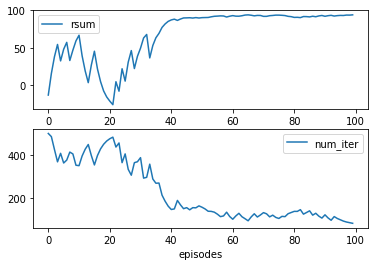

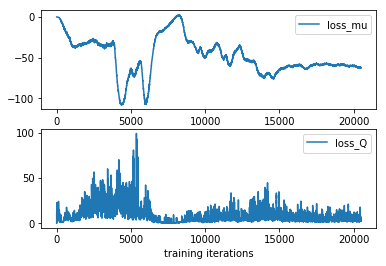

In [6]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(smooth(y, 0.7), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = agent.log_dict.keys()
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
plt.xlabel("training iterations")
plt.show()


## LunarLander

In [16]:
update_freq = 100
num_updates=1
batch_size=100
params = {
'roh':.99,
'gamma':0.99, 
'lr_mu':1e-3
}


env_methods = LunarLanderContinuousMethods()
env = gym.make(env_methods.get_env_name())
obs0 = env.reset()
agent = DDPGAgent(params, obs0=obs0, action_space=env.action_space,
                  update_freq=update_freq, num_updates=num_updates, 
                  batch_size=batch_size, env_methods=env_methods)

out = train_agent(agent, env, num_iter=None, num_episodes=1000, max_iter=500)
play_one_run(agent, env, verbose=2)



env_name = 'LunarLanderContinuous-v2'
Episode 1	num_iter=112	DONE    	rsum=-293.6043134130085
Episode 2	num_iter=61	DONE    	rsum=-105.1347598041547
Episode 3	num_iter=75	DONE    	rsum=-378.41419857751293
Episode 4	num_iter=80	DONE    	rsum=-650.9919545848985
Episode 5	num_iter=210	DONE    	rsum=-439.7987871565805
Episode 6	num_iter=160	DONE    	rsum=-288.17983762276367
Episode 7	num_iter=86	DONE    	rsum=-238.81803958596677
Episode 8	num_iter=89	DONE    	rsum=-423.30342693877674
Episode 9	num_iter=83	DONE    	rsum=-385.50648648518
Episode 10	num_iter=137	DONE    	rsum=-186.29601636609038
Episode 11	num_iter=89	DONE    	rsum=-204.91293304732557
Episode 12	num_iter=79	DONE    	rsum=-379.97170485897436
Episode 13	num_iter=63	DONE    	rsum=-141.63697445458817
Episode 14	num_iter=67	DONE    	rsum=-156.67703687186173
Episode 15	num_iter=56	DONE    	rsum=-102.03717161117184
Episode 16	num_iter=64	DONE    	rsum=-305.62237371238206
Episode 17	num_iter=74	DONE    	rsum=-601.3836750671628
Episod

Episode 146	num_iter=86	DONE    	rsum=-454.81945823586165
Episode 147	num_iter=97	DONE    	rsum=-317.1303056338372
Episode 148	num_iter=88	DONE    	rsum=-159.3181882712088
Episode 149	num_iter=59	DONE    	rsum=-218.41652411735228
Episode 150	num_iter=101	DONE    	rsum=-423.58585540862595
Episode 151	num_iter=114	DONE    	rsum=-670.6255322403708
Episode 152	num_iter=85	DONE    	rsum=-358.59470202595554
Episode 153	num_iter=59	DONE    	rsum=-123.88250132045988
Episode 154	num_iter=97	DONE    	rsum=-535.4329929466993
Episode 155	num_iter=79	DONE    	rsum=-546.4531250833704
Episode 156	num_iter=170	DONE    	rsum=-163.03782635147064
Episode 157	num_iter=93	DONE    	rsum=-380.3163258617409
Episode 158	num_iter=52	DONE    	rsum=-245.42644553943327
Episode 159	num_iter=92	DONE    	rsum=-463.267980200717
Episode 160	num_iter=84	DONE    	rsum=-218.96955989416566
Episode 161	num_iter=70	DONE    	rsum=-416.14522656299204
Episode 162	num_iter=102	DONE    	rsum=-474.08363663990605
Episode 163	num_it

Episode 288	num_iter=77	DONE    	rsum=-77.45523042051573
Episode 289	num_iter=76	DONE    	rsum=-118.40009294102641
Episode 290	num_iter=175	DONE    	rsum=-238.3803958392379
Episode 291	num_iter=117	DONE    	rsum=-258.9656121583092
Episode 292	num_iter=78	DONE    	rsum=-70.99358820749691
Episode 293	num_iter=166	DONE    	rsum=-42.52625321070206
Episode 294	num_iter=99	DONE    	rsum=-76.69814586901623
Episode 295	num_iter=160	DONE    	rsum=-67.19444611446187
Episode 296	num_iter=120	DONE    	rsum=-313.97925391650784
Episode 297	num_iter=128	DONE    	rsum=-397.93248422954014
Episode 298	num_iter=149	DONE    	rsum=-86.21451019157936
Episode 299	num_iter=186	DONE    	rsum=-210.85636052472947
Episode 300	num_iter=284	DONE    	rsum=-307.0109695001694
Episode 301	num_iter=226	DONE    	rsum=-418.91069537494434
Episode 302	num_iter=198	DONE    	rsum=-359.522903290044
Episode 303	num_iter=81	DONE    	rsum=-9.95358441335668
Episode 304	num_iter=382	DONE    	rsum=-261.93055007420105
Episode 305	num

Episode 429	num_iter=267	DONE    	rsum=-108.06068461891971
Episode 430	num_iter=228	DONE    	rsum=-25.990702005517406
Episode 431	num_iter=295	DONE    	rsum=-293.29390931524097
Episode 432	num_iter=254	DONE    	rsum=-284.480547022521
Episode 433	num_iter=500	MAX_ITER	rsum=-33.625951703635906
Episode 434	num_iter=169	DONE    	rsum=-281.534777207281
Episode 435	num_iter=319	DONE    	rsum=-243.74666106217865
Episode 436	num_iter=500	MAX_ITER	rsum=-113.3514296668211
Episode 437	num_iter=500	MAX_ITER	rsum=-90.35300840560403
Episode 438	num_iter=350	DONE    	rsum=-279.6759985342183
Episode 439	num_iter=259	DONE    	rsum=-202.53974414021732
Episode 440	num_iter=500	MAX_ITER	rsum=84.89323469420033
Episode 441	num_iter=154	DONE    	rsum=-181.8506501582433
Episode 442	num_iter=131	DONE    	rsum=-24.39070931984537
Episode 443	num_iter=272	DONE    	rsum=-302.01947108965476
Episode 444	num_iter=207	DONE    	rsum=-337.80168545794504
Episode 445	num_iter=268	DONE    	rsum=-354.9232075673266
Episode 4

Episode 570	num_iter=164	DONE    	rsum=-124.10574855245045
Episode 571	num_iter=236	DONE    	rsum=13.424677964243699
Episode 572	num_iter=500	MAX_ITER	rsum=-88.72789799068025
Episode 573	num_iter=248	DONE    	rsum=-323.0452404141953
Episode 574	num_iter=217	DONE    	rsum=-162.94090333557807
Episode 575	num_iter=260	DONE    	rsum=-276.01943706355917
Episode 576	num_iter=267	DONE    	rsum=-250.7734690263271
Episode 577	num_iter=268	DONE    	rsum=-119.37277863094624
Episode 578	num_iter=203	DONE    	rsum=-78.61681019397982
Episode 579	num_iter=192	DONE    	rsum=-88.39138908836875
Episode 580	num_iter=118	DONE    	rsum=-203.71759347818897
Episode 581	num_iter=300	DONE    	rsum=211.699020551805
Episode 582	num_iter=211	DONE    	rsum=-62.20016823585706
Episode 583	num_iter=166	DONE    	rsum=-108.64841701604931
Episode 584	num_iter=140	DONE    	rsum=-67.72711388345004
Episode 585	num_iter=140	DONE    	rsum=-70.88477585893992
Episode 586	num_iter=101	DONE    	rsum=-149.15769295734574
Episode 5

Episode 711	num_iter=414	DONE    	rsum=-212.54936338886282
Episode 712	num_iter=340	DONE    	rsum=-194.46594842915218
Episode 713	num_iter=416	DONE    	rsum=-180.90861307732507
Episode 714	num_iter=232	DONE    	rsum=-226.3243806466617
Episode 715	num_iter=500	MAX_ITER	rsum=-93.54568327363542
Episode 716	num_iter=500	MAX_ITER	rsum=-17.52189035661447
Episode 717	num_iter=173	DONE    	rsum=-104.22123163900356
Episode 718	num_iter=424	DONE    	rsum=-33.75160541815639
Episode 719	num_iter=500	MAX_ITER	rsum=-38.90291014295659
Episode 720	num_iter=500	MAX_ITER	rsum=-48.3985152880109
Episode 721	num_iter=339	DONE    	rsum=-101.3781900118161
Episode 722	num_iter=500	MAX_ITER	rsum=-68.76102233034808
Episode 723	num_iter=368	DONE    	rsum=-162.37143255664998
Episode 724	num_iter=140	DONE    	rsum=-191.58409911837043
Episode 725	num_iter=392	DONE    	rsum=-221.13505968565255
Episode 726	num_iter=500	MAX_ITER	rsum=-55.39881085869706
Episode 727	num_iter=500	MAX_ITER	rsum=-72.59483564364461
Episode 

Episode 852	num_iter=500	MAX_ITER	rsum=-18.610011727269
Episode 853	num_iter=500	MAX_ITER	rsum=-42.514075519804734
Episode 854	num_iter=500	MAX_ITER	rsum=-7.4614400405593075
Episode 855	num_iter=500	MAX_ITER	rsum=-15.254867701043809
Episode 856	num_iter=500	MAX_ITER	rsum=-18.27660500513705
Episode 857	num_iter=500	MAX_ITER	rsum=-27.48035384058016
Episode 858	num_iter=131	DONE    	rsum=-110.60255489344384
Episode 859	num_iter=500	MAX_ITER	rsum=-31.90907139058696
Episode 860	num_iter=500	MAX_ITER	rsum=-47.98029869820899
Episode 861	num_iter=500	MAX_ITER	rsum=4.507201104223157
Episode 862	num_iter=500	MAX_ITER	rsum=-32.838271733818914
Episode 863	num_iter=500	MAX_ITER	rsum=-26.09155515151119
Episode 864	num_iter=500	MAX_ITER	rsum=-0.6119286852589274
Episode 865	num_iter=500	MAX_ITER	rsum=19.789519031313915
Episode 866	num_iter=500	MAX_ITER	rsum=44.59306027133516
Episode 867	num_iter=500	MAX_ITER	rsum=-18.486220577407824
Episode 868	num_iter=243	DONE    	rsum=-79.98710484070996
Episode 869

Episode 994	num_iter=500	MAX_ITER	rsum=35.63930499833072
Episode 995	num_iter=418	DONE    	rsum=-84.13587818807184
Episode 996	num_iter=313	DONE    	rsum=-60.18653573413498
Episode 997	num_iter=371	DONE    	rsum=-72.05313495935906
Episode 998	num_iter=500	MAX_ITER	rsum=4.589856119169302
Episode 999	num_iter=477	DONE    	rsum=-66.71440203203045
Episode 1000	num_iter=500	MAX_ITER	rsum=-7.453752685106651
num_iter=501	MAX_ITER	rsum=-20.739465388504584


(-20.739465388504584, 501, False)

In [18]:
# import pickle as pkl
# with open('output_tme7_lunar.pkl', 'rb') as f:
#     out = pkl.load(f)

# with open('output_tme7_lunar.pkl', 'wb') as f:
#     pkl.dump(out, f)
print(out['rsum'])

[(1, -293.6043134130085), (2, -105.1347598041547), (3, -378.41419857751293), (4, -650.9919545848985), (5, -439.7987871565805), (6, -288.17983762276367), (7, -238.81803958596677), (8, -423.30342693877674), (9, -385.50648648518), (10, -186.29601636609038), (11, -204.91293304732557), (12, -379.97170485897436), (13, -141.63697445458817), (14, -156.67703687186173), (15, -102.03717161117184), (16, -305.62237371238206), (17, -601.3836750671628), (18, -332.0439791087008), (19, -275.7546176708694), (20, -312.11032401217045), (21, -176.06619935403248), (22, -500.1287317895536), (23, -115.03379787093877), (24, -92.33609012620404), (25, -198.64210831862727), (26, -355.47979037568905), (27, -561.0461506534755), (28, -220.08777086567505), (29, -438.84419150577423), (30, -277.12372639325326), (31, -183.45763471611727), (32, -121.39959443162957), (33, -71.60937757296733), (34, -237.07138413646874), (35, -242.3231658297507), (36, -279.4667498508511), (37, -377.02190412000897), (38, -386.27937490629057)

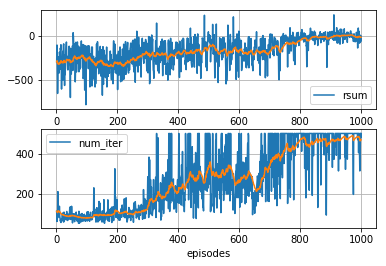

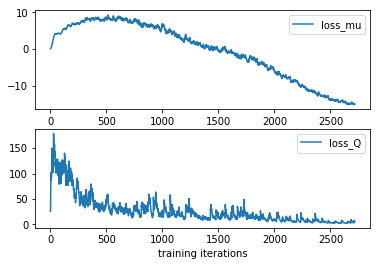

In [17]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.94))
    plt.legend()
    plt.grid()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()



## Pendule

In [13]:

update_freq = 1
num_updates=1
batch_size=100
eps = .5
params = {
'roh':.99,
'gamma':0.99, 
}


env_methods = PendulumContinuousMethods()
env = gym.make(env_methods.get_env_name())
obs0 = env.reset()
agent = DDPGAgent(params, obs0=obs0, action_space=env.action_space,
                  update_freq=update_freq, num_updates=num_updates, 
                  batch_size=batch_size, env_methods=env_methods)

out = train_agent(agent, env, num_iter=None, num_episodes=100, max_iter=201)
play_one_run(agent, env, verbose=2)


env_name = 'Pendulum-v0'
Episode 1	num_iter=200	DONE    	rsum=-1318.0093715835162
Episode 2	num_iter=200	DONE    	rsum=-1347.9608154636578
Episode 3	num_iter=200	DONE    	rsum=-1173.3534677623743
Episode 4	num_iter=200	DONE    	rsum=-1207.5735936185179
Episode 5	num_iter=200	DONE    	rsum=-1609.509561640845
Episode 6	num_iter=200	DONE    	rsum=-1254.9863057152395
Episode 7	num_iter=200	DONE    	rsum=-1715.3853401106853
Episode 8	num_iter=200	DONE    	rsum=-1531.0291527552276
Episode 9	num_iter=200	DONE    	rsum=-1595.7468937147794
Episode 10	num_iter=200	DONE    	rsum=-1619.8692492464465
Episode 11	num_iter=200	DONE    	rsum=-1188.5672991407926
Episode 12	num_iter=200	DONE    	rsum=-1109.9695363645208
Episode 13	num_iter=200	DONE    	rsum=-998.5608613584454
Episode 14	num_iter=200	DONE    	rsum=-866.027521328191
Episode 15	num_iter=200	DONE    	rsum=-755.7113216123057
Episode 16	num_iter=200	DONE    	rsum=-779.136626472369
Episode 17	num_iter=200	DONE    	rsum=-760.9155505975191
Episod

(-116.65353852726045, 200, True)

In [29]:
# import pickle as pkl
# with open('output_tme7_pendulum.pkl', 'wb') as f:
#     pkl.dump(out, f)

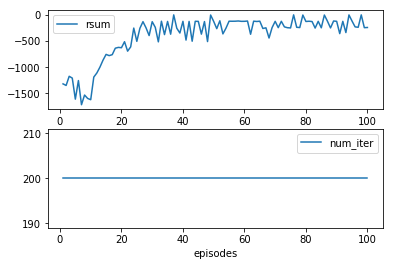

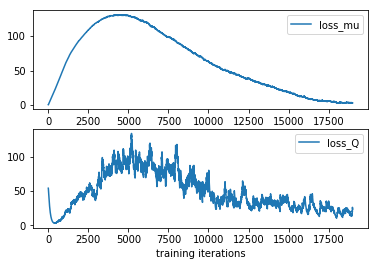

In [15]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = agent.log_dict.keys()
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.99), label=k)
    plt.legend()
plt.xlabel("training iterations")
plt.show()


>> On observe de bons résultats sur les 3 problèmes